# Predicting Mortality in Heart Failure Patients

### Dataset Summary
This dataset contains 299 clinical records of patients who experienced heart failure. 
It includes 12 features:
* **age**: The age of the patient.
* **anaemia**: Presence of anemia in the patient (1 = Yes, 0 = No).
* **creatinine_phosphokinase**: Level of the enzyme creatinine phosphokinase in the blood (measured in mcg/L).
* **diabetes**: Whether the patient has diabetes (1 = Yes, 0 = No).
* **ejection_fraction**: Percentage of blood leaving the heart with each contraction (measured in percentage).
* **high_blood_pressure**: Whether the patient has high blood pressure (1 = Yes, 0 = No).
* **platelets**: Number of platelets in the blood (measured in kiloplatelets/mL).
* **serum_creatinine**: Level of serum creatinine in the blood (measured in mg/dL).
* **serum_sodium**: Level of serum sodium in the blood (measured in mEq/L).
* **sex**: The biological sex of the patient (1 = Male, 0 = Female).
* **smoking**: Whether the patient smokes (1 = Yes, 0 = No).
* **time**: Follow-up period for the patient (measured in days).
* **DEATH_EVENT**: The target variable indicating if the patient died during the follow-up period (1 = Yes, 0 = No).

Citation: Davide Chicco, Giuseppe Jurman: Machine learning can predict survival of patients with heart failure from serum creatinine and ejection fraction alone. BMC Medical Informatics and Decision Making 20, 16 (2020).

## Import essential libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from xgboost import XGBClassifier
from sklearn.svm import SVC

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Import the dataset

In [4]:
df = pd.read_csv('heart_failure_clinical_records_dataset.csv')
print(df.head())

    age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
0  75.0        0                       582         0                 20   
1  55.0        0                      7861         0                 38   
2  65.0        0                       146         0                 20   
3  50.0        1                       111         0                 20   
4  65.0        1                       160         1                 20   

   high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \
0                    1  265000.00               1.9           130    1   
1                    0  263358.03               1.1           136    1   
2                    0  162000.00               1.3           129    1   
3                    0  210000.00               1.9           137    1   
4                    0  327000.00               2.7           116    0   

   smoking  time  DEATH_EVENT  
0        0     4            1  
1        0     6            1  
2       

## Data Inspection and Cleaning

In [4]:
print("Data types of each column:")
print(df.info())

Data types of each column:
<class 'pandas.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB
No

In [8]:
print("Missing values in each column:")
print(df.isna().sum())

Missing values in each column:
age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64


In [10]:
print("Number of duplicate rows: ")
print(df.duplicated().sum())

Number of duplicate rows: 
0


We have 299 entries, 0 dupicates and 0 missing values across all columns. All features are numerical (`int64` or `float64`). 

In [5]:
print('Summary statistics:')
print(df.describe())

Summary statistics:
              age     anaemia  creatinine_phosphokinase    diabetes  \
count  299.000000  299.000000                299.000000  299.000000   
mean    60.833893    0.431438                581.839465    0.418060   
std     11.894809    0.496107                970.287881    0.494067   
min     40.000000    0.000000                 23.000000    0.000000   
25%     51.000000    0.000000                116.500000    0.000000   
50%     60.000000    0.000000                250.000000    0.000000   
75%     70.000000    1.000000                582.000000    1.000000   
max     95.000000    1.000000               7861.000000    1.000000   

       ejection_fraction  high_blood_pressure      platelets  \
count         299.000000           299.000000     299.000000   
mean           38.083612             0.351171  263358.029264   
std            11.834841             0.478136   97804.236869   
min            14.000000             0.000000   25100.000000   
25%            30.00

The average age is about 60.8 years, with a range from 40 to 95. Our model will be trained on a middle-aged to elderly population.

The mean for the target variable, `DEATH_EVENT` is around 0.32, which means ~32% of the patients died and ~68% survived. This is a slight imbalance. We will focus on Precision-Recall and F1-Score rather than just Accuracy to ensure the model actually learns to identify high-risk patients.

Because features like `platelets` and `creatinine_phosphokinase` have much larger magnitudes than features like `high_blood_pressure` and `serum_creatinine`, features scaling will be necessary so that the models do not prioritize features with large magnitudes.

## Exploratory Data Analysis

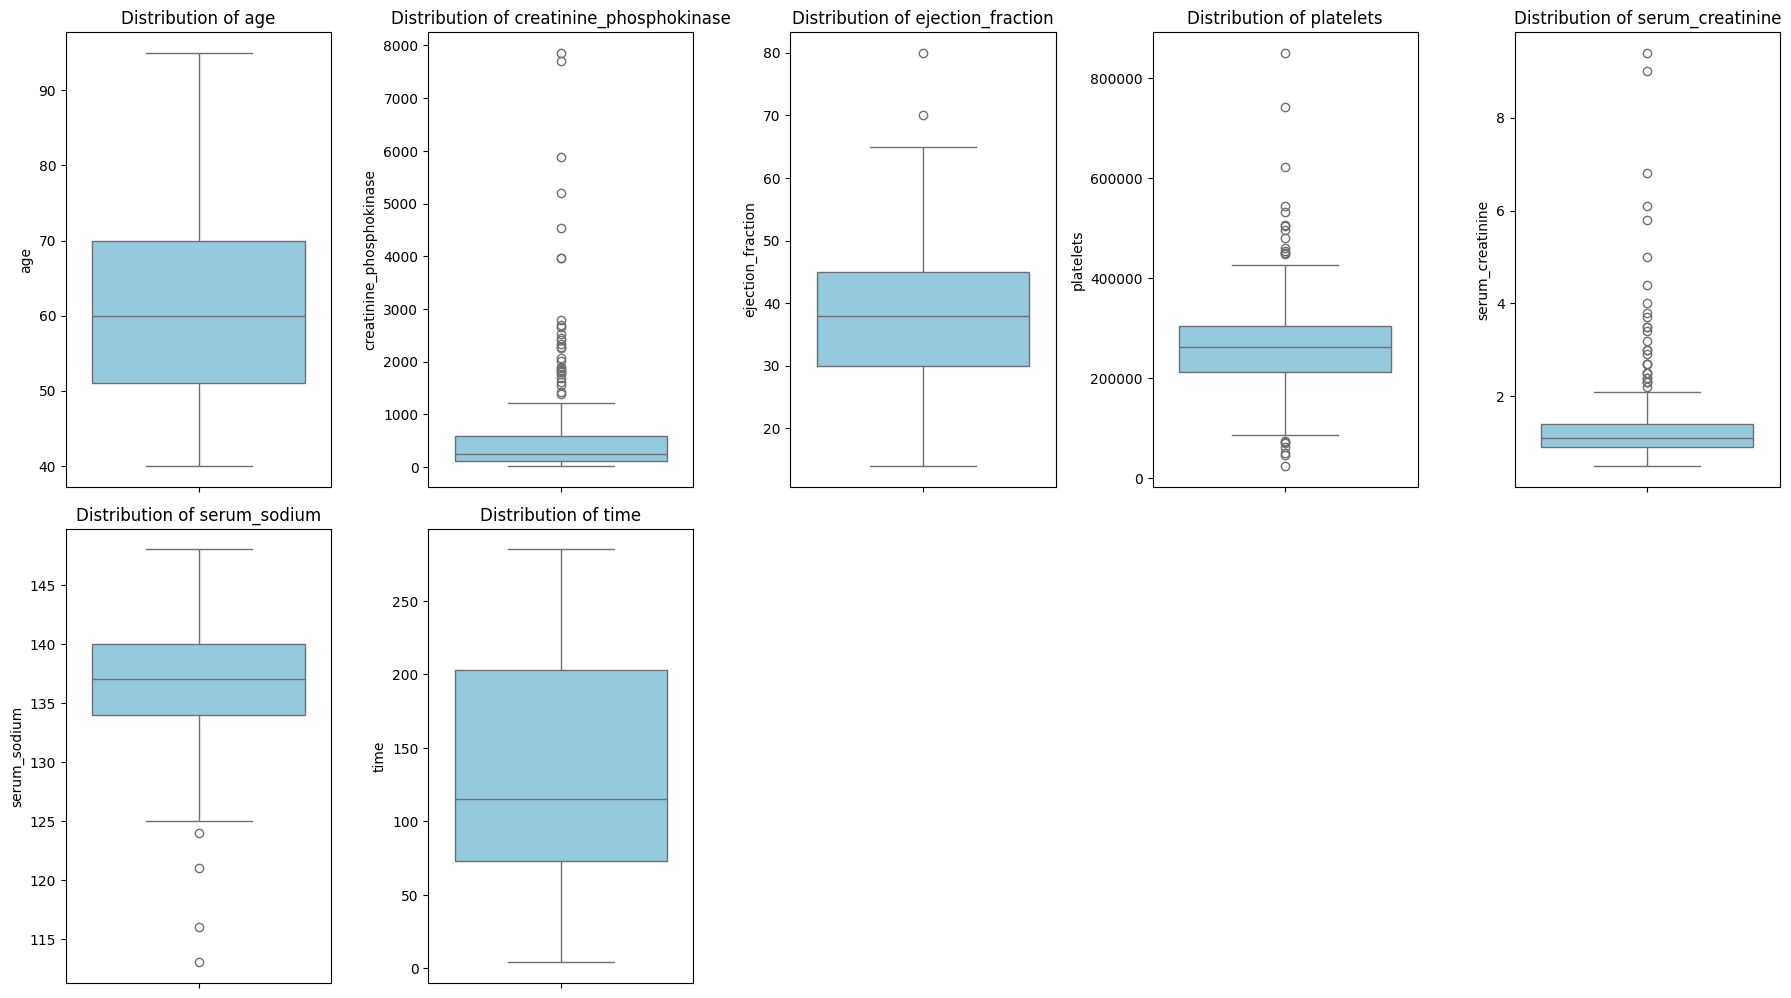

In [64]:
# List of numerical columns (exclusing binary 0/1 columns for better visualizaton)
num_cols = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']

plt.figure(figsize=(18,15))
for i, col in enumerate(num_cols, 1):
    plt.subplot(3,5,i)
    sns.boxplot(y=df[col], color='skyblue')
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

`creatinine_phosphokinase` and `serum_creatinine` show significant right-skewness and outliers. In medicine, `creatinine_phosphokinase` levels can spike dramatically during a heart attack, so these values most likely represent the at-risk patients. 

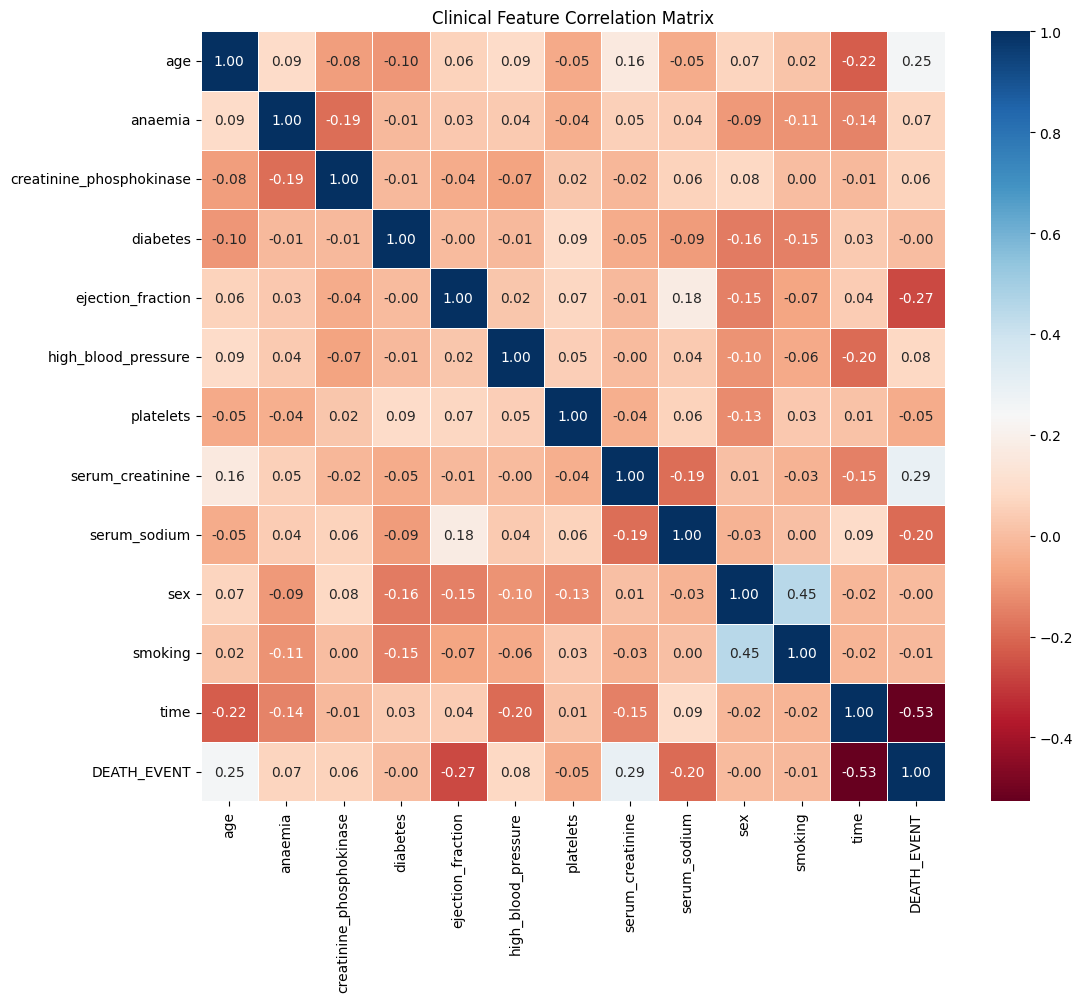

In [20]:
plt.figure(figsize=(12,10))

corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdBu', fmt='.2f', linewidths=0.5)
plt.title('Clinical Feature Correlation Matrix')
plt.show()

In [21]:
correlations = df.corr()['DEATH_EVENT'].sort_values(ascending=False)
print('Correlation with DEATH_EVENT (Highest to Lowest): ')
print(correlations)

Correlation with DEATH_EVENT (Highest to Lowest): 
DEATH_EVENT                 1.000000
serum_creatinine            0.294278
age                         0.253729
high_blood_pressure         0.079351
anaemia                     0.066270
creatinine_phosphokinase    0.062728
diabetes                   -0.001943
sex                        -0.004316
smoking                    -0.012623
platelets                  -0.049139
serum_sodium               -0.195204
ejection_fraction          -0.268603
time                       -0.526964
Name: DEATH_EVENT, dtype: float64


* `time` shows the strongest correlation. It is negative, which means patients with shorter follow-up times were more likely to have a `DEATH_EVENT` recoreded.
* `serum_creatinine` and `age` show positive correlation. As these values go up, the risk for death increases. This makes sense, as older patients and those with kidney stress (high creatinine) are at higher risk.
* `serum_sodium` and `ejection_fraction` shows negative correlation. Lower sodium levels are a known risk factor in heart failure. As the heart's pumping efficiency drops, the risk of death rises.
* Other features, including `diabetes`, `sex`, `smoking` do not show strong linear correlation with death in this dataset. They may have non-linear relationships that can make them useful for our models later.

## Data Splitting and Scaling

In [5]:
# Separate features and target
X = df.drop('DEATH_EVENT', axis=1)
y = df['DEATH_EVENT']

# Split into training set (80%) and tesing set (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Apply SMOTE to training data only
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

In [60]:
print('Shape of X_train: ', X_train.shape)
print('Shape of y_train: ', y_train.shape)
print('Shape of X_test: ', X_test.shape)
print('Shape of y_test: ', y_test.shape)

Shape of X_train:  (239, 12)
Shape of y_train:  (239,)
Shape of X_test:  (60, 12)
Shape of y_test:  (60,)


## Support Vector Machine (SVM)

In [13]:
# Define the grid
param_grid_svm = {
    'C': [1, 10, 100],      
    'kernel': ['linear', 'rbf']
}

# Initialize Grid Search
grid_svm = GridSearchCV(
    SVC(random_state=42), 
    param_grid_svm, 
    refit=True, 
    verbose=1, 
    cv=5, 
    scoring='f1' 
)

# Fit using the resampled data
grid_svm.fit(X_train_scaled, y_train_res)

# Results
print("Best parameters found: ", grid_svm.best_params_)

# Predict on the original scaled test data
y_pred_svm = grid_svm.predict(X_test_scaled)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters found:  {'C': 1, 'kernel': 'rbf'}


Optimized SVM Results:
Accuracy: 0.8
Classification_report: 
              precision    recall  f1-score   support

           0       0.85      0.85      0.85        41
           1       0.68      0.68      0.68        19

    accuracy                           0.80        60
   macro avg       0.77      0.77      0.77        60
weighted avg       0.80      0.80      0.80        60



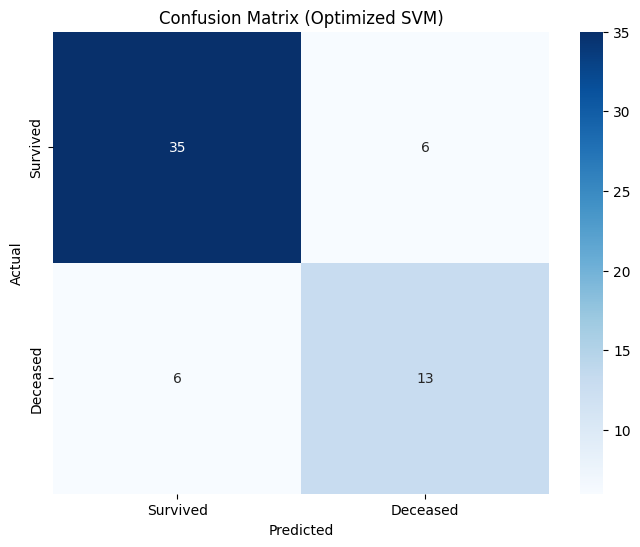

In [14]:
print("Optimized SVM Results:")
print('Accuracy:', accuracy_score(y_test, y_pred_svm))
print('Classification_report: ')
print(classification_report(y_test, y_pred_svm))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Survived', 'Deceased'], yticklabels=['Survived', 'Deceased'])
plt.title('Confusion Matrix (Optimized SVM)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## XGBoost

In [6]:
# Define the parameter grid
param_grid_xgb = {
    'n_estimators': [500, 1000, 1500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0] 
}

# Initialize Grid Search
grid_xgb = GridSearchCV(
    estimator=XGBClassifier(random_state=42),
    param_grid=param_grid_xgb,
    cv=5,
    scoring='f1', 
    n_jobs=-1 
)

# Fit using resampled data
grid_xgb.fit(X_train_res, y_train_res)

# Results
print("Best Parameters found:", grid_xgb.best_params_)
best_xgb_model = grid_xgb.best_estimator_

# Predict on the original X_test
y_pred_xgb = best_xgb_model.predict(X_test)

Best Parameters found: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'subsample': 1.0}


Optimized XGBoost Results:
Accuracy: 0.8166666666666667
Classification_report: 
              precision    recall  f1-score   support

           0       0.86      0.88      0.87        41
           1       0.72      0.68      0.70        19

    accuracy                           0.82        60
   macro avg       0.79      0.78      0.79        60
weighted avg       0.81      0.82      0.82        60



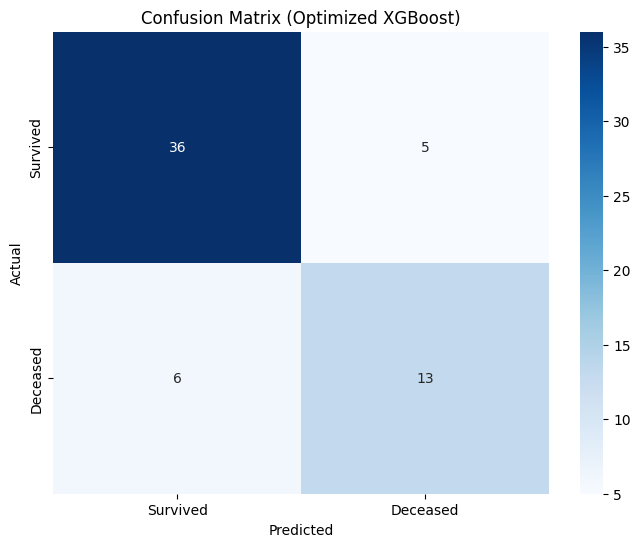

In [7]:
print("Optimized XGBoost Results:")
print('Accuracy:', accuracy_score(y_test, y_pred_xgb))
print('Classification_report: ')
print(classification_report(y_test, y_pred_xgb))
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Survived', 'Deceased'], yticklabels=['Survived', 'Deceased'])
plt.title('Confusion Matrix (Optimized XGBoost)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

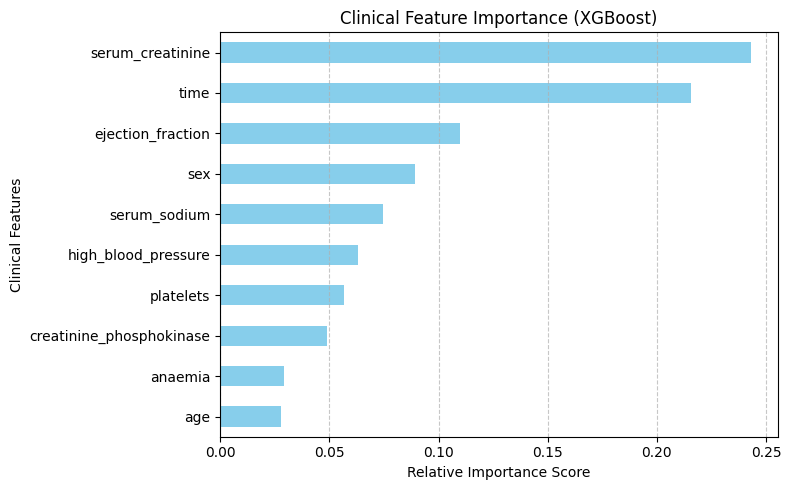

In [12]:
importances = best_xgb_model.feature_importances_
feature_names = X.columns
feature_importances = pd.Series(importances, index=feature_names)

plt.figure(figsize=(8, 5))
feature_importances.nlargest(10).sort_values().plot(kind='barh', color='skyblue')
plt.title('Clinical Feature Importance (XGBoost)')
plt.xlabel('Relative Importance Score')
plt.ylabel('Clinical Features')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Artificial Neural Network

In [66]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_res.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Create a dataset and loader (batches of 16)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [67]:
class HeartFailureNet(nn.Module):
    def __init__(self):
        super(HeartFailureNet, self).__init__()
        # Input: 12 features -> 16 hidden nodes
        self.layer1 = nn.Linear(12, 16)
        # Dropout helps prevent overfitting on this small 299-row dataset
        self.dropout = nn.Dropout(0.2)
        # 16 hidden nodes -> 8 hidden nodes
        self.layer2 = nn.Linear(16, 8)
        # Output layer: 1 node (Death or Survival)
        self.output = nn.Linear(8, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.dropout(x)
        x = self.relu(self.layer2(x))
        x = self.sigmoid(self.output(x))
        return x

model = HeartFailureNet()

In [68]:
# Loss and Optimizer
criterion = nn.BCELoss() # Binary Cross Entropy for 0/1 classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 1000
for epoch in range(epochs):
    for batch_X, batch_y in train_loader:
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass (Learning)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

Neural Network Result: 
Accuracy: 0.7666666666666667
Classification report:
              precision    recall  f1-score   support

         0.0       0.81      0.85      0.83        41
         1.0       0.65      0.58      0.61        19

    accuracy                           0.77        60
   macro avg       0.73      0.72      0.72        60
weighted avg       0.76      0.77      0.76        60



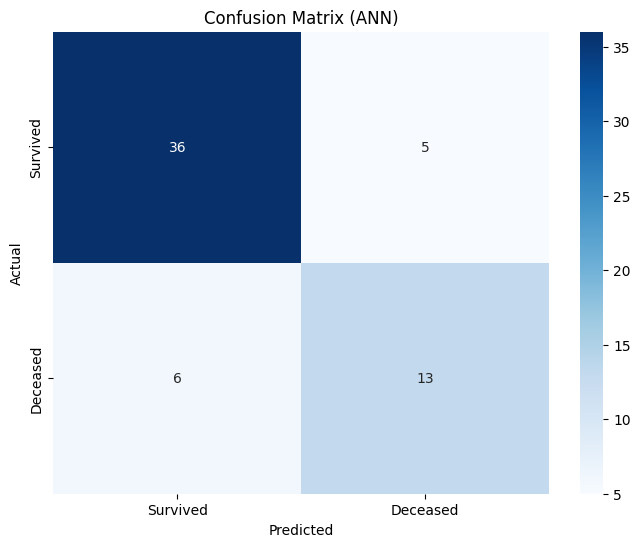

In [69]:
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    y_pred_nn = (predictions > 0.5).float()

print('Neural Network Result: ')
print('Accuracy:', accuracy_score(y_test, y_pred_nn))
print('Classification report:')    
print(classification_report(y_test_tensor, y_pred_nn))
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Survived', 'Deceased'], yticklabels=['Survived', 'Deceased'])
plt.title('Confusion Matrix (ANN)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Summary

* **XGBoost** performed the best overall. It achieved the highest accuracy (82%) and the best balance between precision and recall.

* **SVM** showed a strong ability to catch deaths (68% recall) but had a few more false alarms than XGBoost.

* **Neural Network** struggled more than the others. This is likely because our dataset of 299 patients is quite small, and deep learning models usually work better with much larger amounts of data.
